# PSM-Net

Source: https://github.com/JiaRenChang/PSMNet.

Download the pretrained model from [here](https://drive.google.com/file/d/1pHWjmhKMG4ffCrpcsp_MTXMJXhgl3kF9/view?usp=sharing).

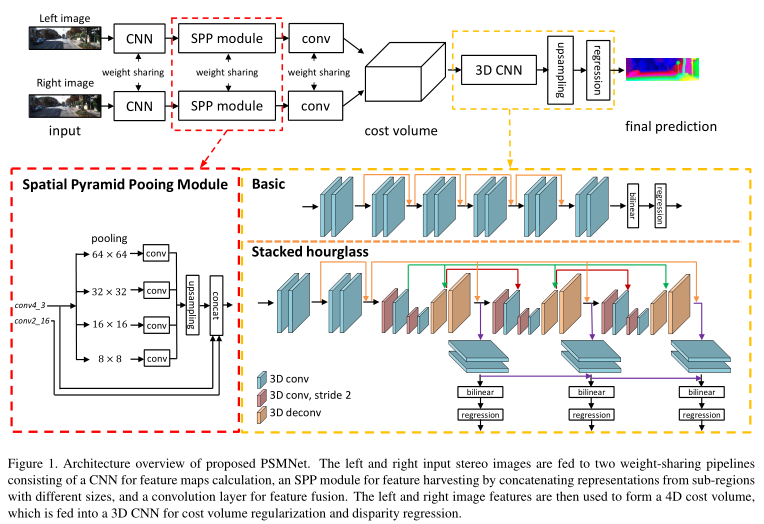

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import time
import cv2
from PIL import Image

from lib.psmnet.stacked_hourglass import PSMNet


maxdisp = 192
model_file = 'pretrained_model_KITTI2015.tar'
left_img = './data/view_left.png'
right_img = './data/view_right.png'


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = PSMNet(maxdisp)
model = nn.DataParallel(model, device_ids=[0])
state_dict = torch.load(model_file, map_location=device)
model.load_state_dict(state_dict['state_dict'])
model = model.module.eval()
model.to(device)

print('Number of model parameters: {}'.format(sum([p.data.nelement() for p in model.parameters()])))



normal_mean_var = {'mean': [0.485, 0.456, 0.406],
                    'std': [0.229, 0.224, 0.225]}
infer_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(**normal_mean_var)])    

imgL_o = Image.open(left_img).convert('RGB')
imgR_o = Image.open(right_img).convert('RGB')

imgL = infer_transform(imgL_o)
imgR = infer_transform(imgR_o) 


# pad to width and height to 16 times
if imgL.shape[1] % 16 != 0:
    times = imgL.shape[1]//16       
    top_pad = (times+1)*16 -imgL.shape[1]
else:
    top_pad = 0

if imgL.shape[2] % 16 != 0:
    times = imgL.shape[2]//16                       
    right_pad = (times+1)*16-imgL.shape[2]
else:
    right_pad = 0    

imgL = F.pad(imgL,(0,right_pad, top_pad,0)).unsqueeze(0)
imgR = F.pad(imgR,(0,right_pad, top_pad,0)).unsqueeze(0)

imgL = imgL.to(device)
imgR = imgR.to(device)

start_time = time.time()
with torch.no_grad():
    disp = model(imgL,imgR)
print('time = %.2f' %(time.time() - start_time))

disp = torch.squeeze(disp)
pred_disp = disp.data.cpu().numpy()

if top_pad != 0 and right_pad != 0:
    img = pred_disp[top_pad:,:-right_pad]
elif top_pad == 0 and right_pad != 0:
    img = pred_disp[:,:-right_pad]
elif top_pad != 0 and right_pad == 0:
    img = pred_disp[top_pad:,:]
else:
    img = pred_disp

img = (img*256).astype('uint16')
img = Image.fromarray(img)

Number of model parameters: 5224768
Computing left features...
Computing right features...
Computing cost volumes...


/home/fdf/clones/maibi_cv/.venv/lib/python3.6/site-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/fdf/clones/maibi_cv/.venv/lib/python3.6/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/home/fdf/clones/maibi_cv/.venv/lib/python3.6/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Up

Regressing disparity...
time = 15.02


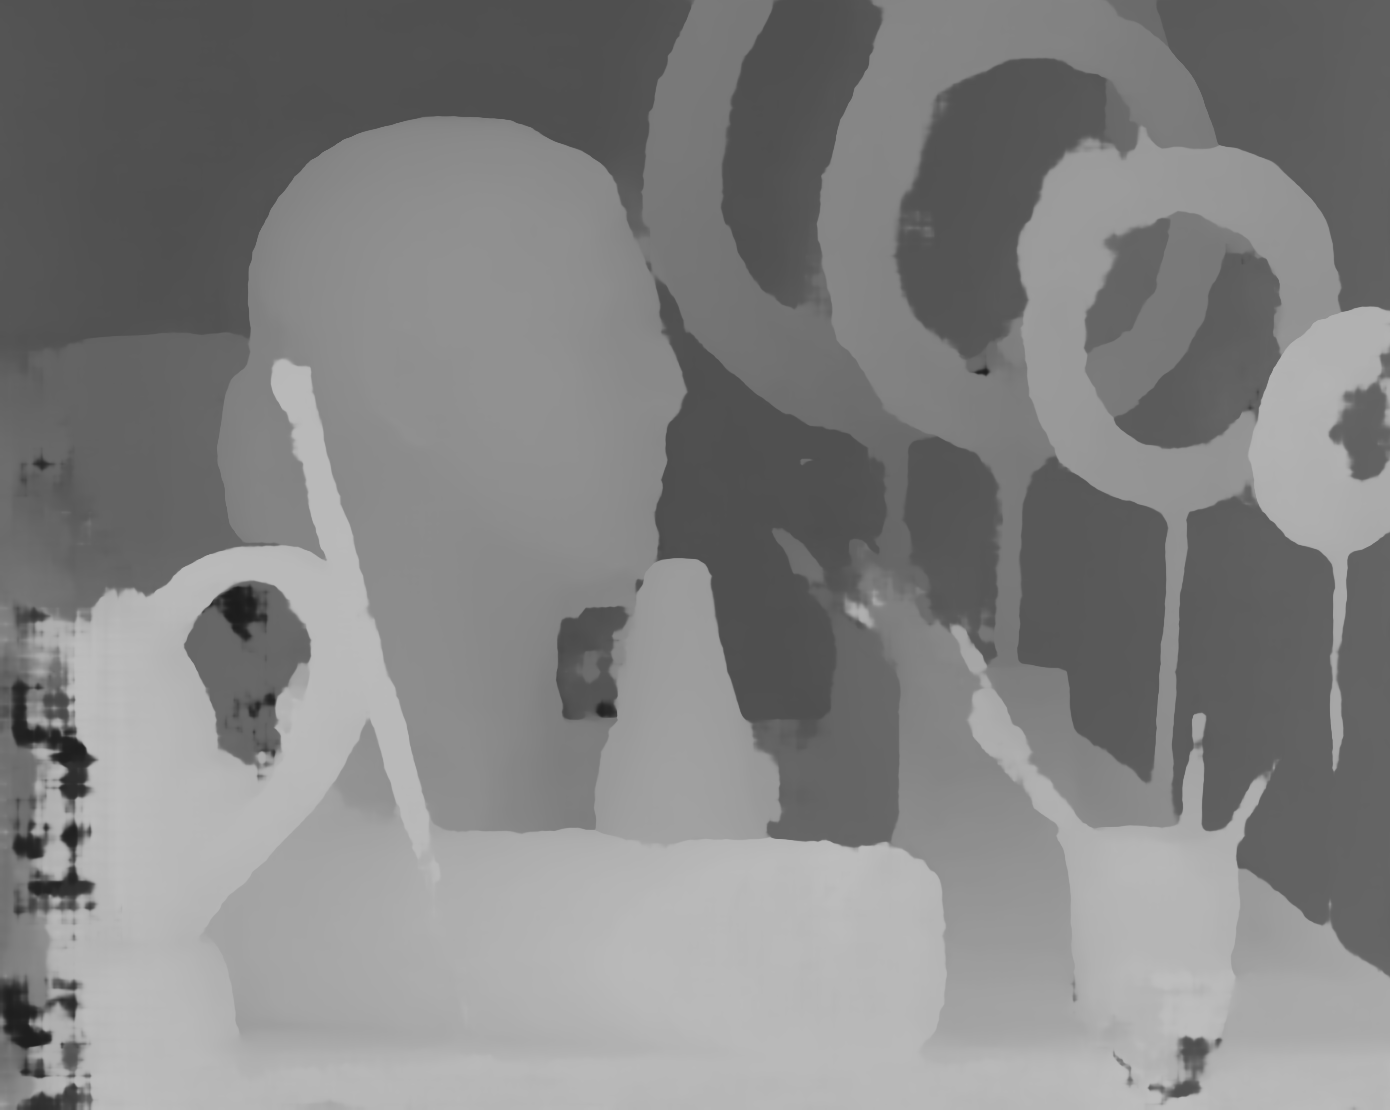

In [2]:
img